本 Notebook  **Surface-17 / rotated d=3** 拓扑（9 个 data + 8 个 ancilla），做到：

1. **拓扑图**：显示每个 ancilla（`az*`/`ax*`）与其相连的 data（`d*`）的显式连接关系（连线图）。  
2. **电路图**：生成一轮（one round）综合征提取电路，并在左侧用 `d0,d1,...,az0,...,ax3` 命名，不再出现 `q0,q1,...`。  
3. **模块化解释**：用 Markdown 分解每一步在做什么（Reset / Z-check / X-check）。  
4. **纠错示例**：注入一个 X 错误，提取综合征，做教学级“查表解码”，反馈纠正，再测一轮验证。

说明：这里用 CNOT 表达 stabilizer 测量（Qiskit/Aer 直观）。硬件上可进一步做 CZ 原生门与 no-hook 调度。


In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit import transpile
import matplotlib.pyplot as plt

## 1. d=3 Surface Code 拓扑结构（信息比特 & 辅助比特， 对齐 Surface‑17 / rotated d=3）

信息比特（data qubit）构成 3×3 网格：

    d0 —— d1 —— d2
     |     |     |
    d3 —— d4 —— d5
     |     |     |
    d6 —— d7 —— d8

Z 稳定子（plaquette）与其对应的辅助比特：

    az0: {d0, d1, d3, d4}
    az1: {d1, d2, d4, d5}
    az2: {d3, d4, d6, d7}
    az3: {d4, d5, d7, d8}

X 稳定子（star）在 d=3 教学模型中与 Z 稳定子作用集合相同，
但测量的是 X⊗X⊗X⊗X。

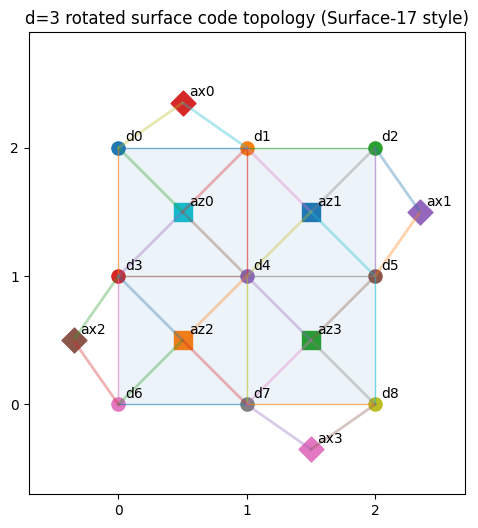

In [3]:
# --- data coordinates on 3x3 grid (for plotting) ---
DATA_COORDS = {i: (i//3, i%3) for i in range(9)}  # (row, col)

def _xy_of_data(dname: str):
    i = int(dname[1:])
    r, c = DATA_COORDS[i]
    return c, 2 - r

# --- stabilizer definitions (Surface-17 style) ---
Z_CHECKS = [
    {"name":"Zp0", "anc":"az0", "data":["d0","d1","d3","d4"]},
    {"name":"Zp1", "anc":"az1", "data":["d1","d2","d4","d5"]},
    {"name":"Zp2", "anc":"az2", "data":["d3","d4","d6","d7"]},
    {"name":"Zp3", "anc":"az3", "data":["d4","d5","d7","d8"]},
]

X_CHECKS = [
    {"name":"Xs0", "anc":"ax0", "data":["d0","d1"]},  # above d0-d1
    {"name":"Xs1", "anc":"ax1", "data":["d2","d5"]},  # right of d2-d5
    {"name":"Xs2", "anc":"ax2", "data":["d3","d6"]},  # left of d3-d6
    {"name":"Xs3", "anc":"ax3", "data":["d7","d8"]},  # below d7-d8 (edit if needed)
]

# Explicit ancilla plot positions to match your Surface-17 drawing
Z_ANC_POS = {0:(0.5,1.5), 1:(1.5,1.5), 2:(0.5,0.5), 3:(1.5,0.5)}
X_ANC_POS = {0:(0.5,2.35), 1:(2.35,1.5), 2:(-0.35,0.5), 3:(1.5,-0.35)}

def plot_surface17_topology():
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)

    # data nodes + grid edges
    for i,(r,c) in DATA_COORDS.items():
        x,y = c, 2-r
        ax.scatter([x],[y], s=90)
        ax.text(x+0.05, y+0.05, f"d{i}", fontsize=10)
        if c < 2: ax.plot([x, x+1], [y, y], linewidth=1, alpha=0.6)
        if r < 2: ax.plot([x, x], [y, y-1], linewidth=1, alpha=0.6)

    # Z ancillas + connections + translucent plaquettes
    for i, stab in enumerate(Z_CHECKS):
        cx,cy = Z_ANC_POS[i]
        ax.scatter([cx],[cy], marker='s', s=160)
        ax.text(cx+0.05, cy+0.05, f"az{i}", fontsize=10)
        for d in stab["data"]:
            x,y = _xy_of_data(d)
            ax.plot([cx,x],[cy,y], linewidth=2, alpha=0.35)
        xs = [_xy_of_data(d)[0] for d in stab["data"]]
        ys = [_xy_of_data(d)[1] for d in stab["data"]]
        ax.add_patch(plt.Rectangle((min(xs), min(ys)), max(xs)-min(xs), max(ys)-min(ys),
                                   fill=True, alpha=0.08))

    # X ancillas + connections
    for i, stab in enumerate(X_CHECKS):
        cx,cy = X_ANC_POS[i]
        ax.scatter([cx],[cy], marker='D', s=160)
        ax.text(cx+0.05, cy+0.05, f"ax{i}", fontsize=10)
        for d in stab["data"]:
            x,y = _xy_of_data(d)
            ax.plot([cx,x],[cy,y], linewidth=2, alpha=0.35)

    ax.set_xlim(-0.7, 2.7); ax.set_ylim(-0.7, 2.9)
    ax.set_xticks([0,1,2]); ax.set_yticks([0,1,2])
    ax.set_aspect('equal', adjustable='box')
    ax.set_title("d=3 rotated surface code topology (Surface-17 style)")
    plt.show()

plot_surface17_topology()


---

## 2. 用 d*/az*/ax* 命名线路：生成一轮综合征提取电路

关键技巧：
- 给每条量子线单独创建 `QuantumRegister(1, "d0")` 这种寄存器
- Qiskit 画电路时左侧会显示这些名字，而不是 `q0,q1,...`

电路模块结构（one round）：
1. Reset ancilla（复位 `az*`、`ax*`）
2. Z-checks：`CNOT(data → az)`，测 `az` 得 `sZ*`
3. Reset X ancilla（推荐）
4. X-checks：`H(ax) → CNOT(ax → data) → H(ax)`，测 `ax` 得 `sX*`


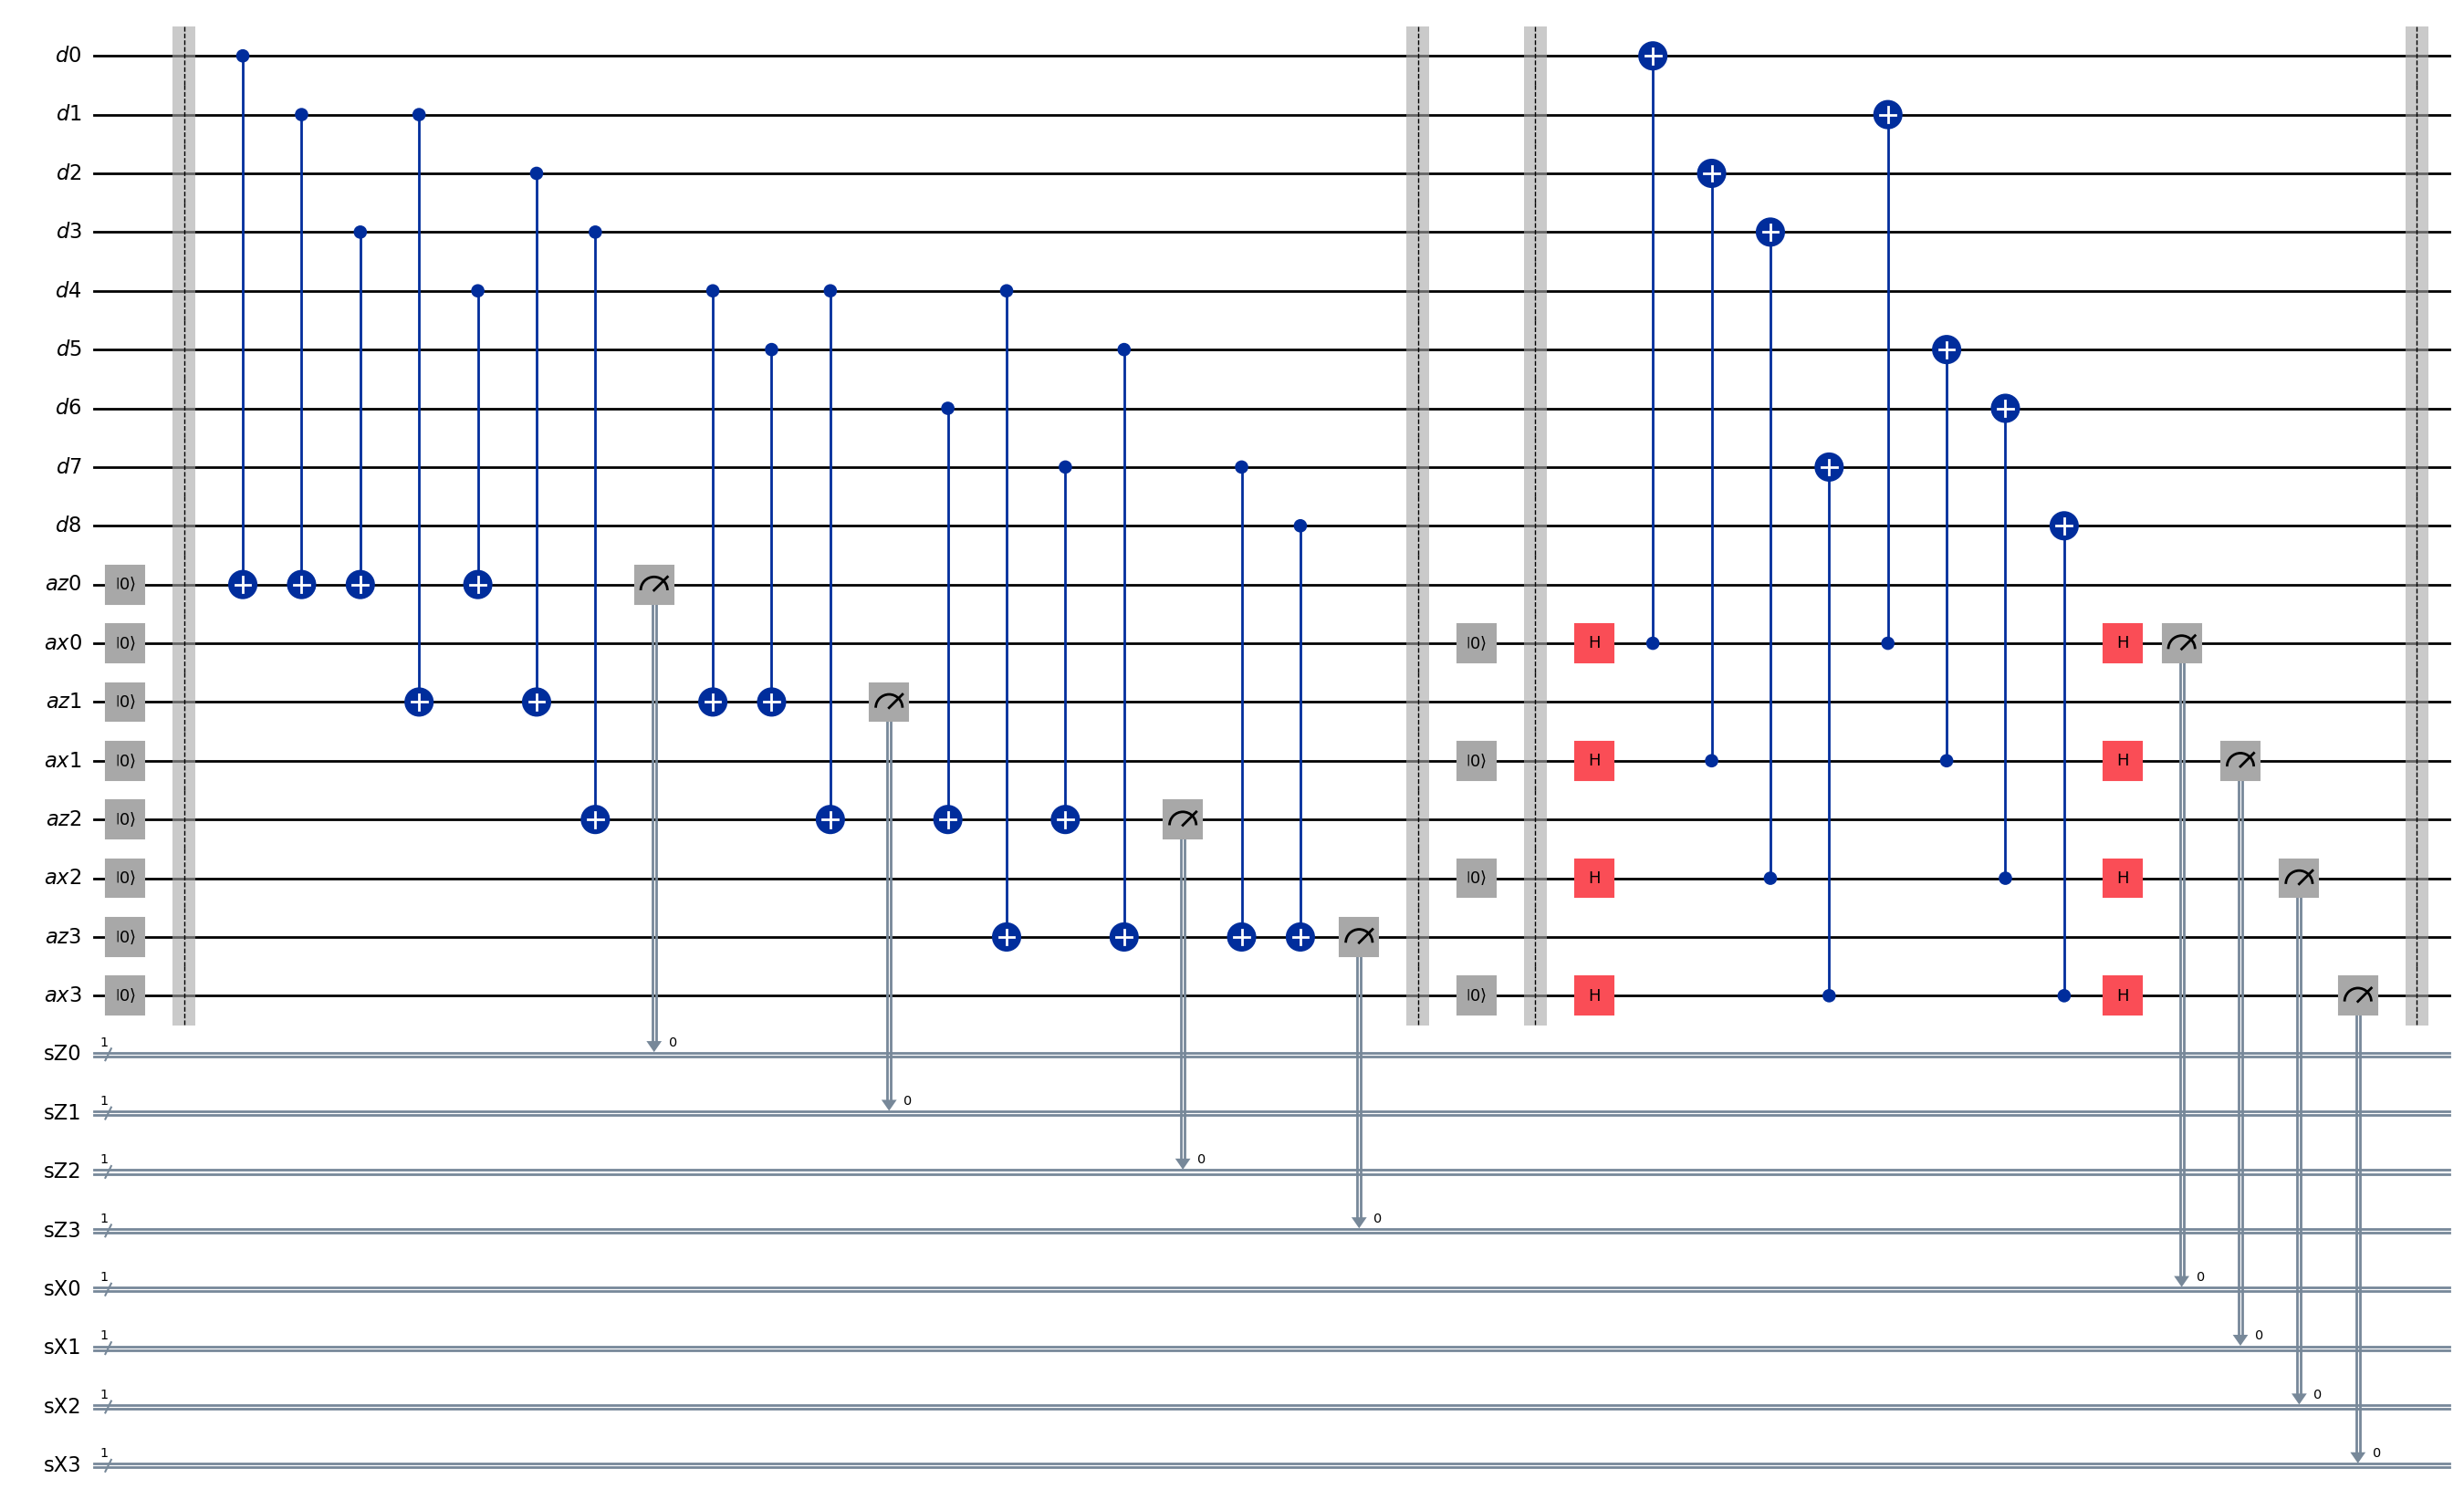

In [4]:
def make_named_qubits():
    qregs = {}
    for i in range(9):
        qregs[f"d{i}"]  = QuantumRegister(1, f"d{i}")
    for i in range(4):
        qregs[f"az{i}"] = QuantumRegister(1, f"az{i}")
        qregs[f"ax{i}"] = QuantumRegister(1, f"ax{i}")
    return qregs

def make_named_syndrome_bits():
    cregs = {}
    for i in range(4):
        cregs[f"sZ{i}"] = ClassicalRegister(1, f"sZ{i}")
    for i in range(4):
        cregs[f"sX{i}"] = ClassicalRegister(1, f"sX{i}")
    return cregs

def Q(qregs, name): return qregs[name][0]
def C(cregs, name): return cregs[name][0]

def reset_ancillas(qc, qregs):
    for i in range(4):
        qc.reset(Q(qregs, f"az{i}"))
        qc.reset(Q(qregs, f"ax{i}"))

def measure_z_checks(qc, qregs, cregs):
    # Z-check: CNOT(data -> anc), then measure anc
    for i, stab in enumerate(Z_CHECKS):
        anc = stab["anc"]
        for d in stab["data"]:
            qc.cx(Q(qregs, d), Q(qregs, anc))
        qc.measure(Q(qregs, anc), C(cregs, f"sZ{i}"))

def measure_x_checks(qc, qregs, cregs):
    # X-check: H(anc), CNOT(anc -> data), H(anc), measure anc
    for i, stab in enumerate(X_CHECKS):
        anc = stab["anc"]
        qc.h(Q(qregs, anc))
        for d in stab["data"]:
            qc.cx(Q(qregs, anc), Q(qregs, d))
        qc.h(Q(qregs, anc))
        qc.measure(Q(qregs, anc), C(cregs, f"sX{i}"))

def build_one_round():
    qregs = make_named_qubits()
    cregs = make_named_syndrome_bits()
    qc = QuantumCircuit(*qregs.values(), *cregs.values(), name="Surface17_1round")

    reset_ancillas(qc, qregs)
    qc.barrier()

    measure_z_checks(qc, qregs, cregs)
    qc.barrier()

    # recommended: reset X ancillas again
    for i in range(4):
        qc.reset(Q(qregs, f"ax{i}"))
    qc.barrier()

    measure_x_checks(qc, qregs, cregs)
    qc.barrier()

    return qc

qc1 = build_one_round()
qc1.draw("mpl", fold=-1)


---

## 3. 模块拆解：每一步在做什么

### 3.1 Reset ancilla
- 把所有测量比特 `az*` / `ax*` 复位到 |0⟩
- 作用：每一轮综合征从确定初态开始，避免上一轮残留影响

### 3.2 Z-check（输出 sZ0..sZ3）
- 对每个 Z-plaquette（例如 `az0` 连接 `d0,d1,d3,d4`）执行：
  - `CNOT(data → az0)`（遍历其邻接 data）
  - 测量 `az0` 得到 `sZ0`
- 含义：`sZ=1` 表示对应 Z-stabilizer 本征值翻转，通常由 X（bit-flip）错误导致

### 3.3 Reset X ancilla
- 再次复位 `ax*`，隔离测量残留对后续模块的影响

### 3.4 X-check（输出 sX0..sX3）
- 对每个边界 X-check（例如 `ax1` 连接 `d2,d5`）执行：
  - `H(ax1)`（切换到 X 测量基）
  - `CNOT(ax1 → data)`（遍历其邻接 data）
  - `H(ax1)`（切回 Z 基）
  - 测量 `ax1` 得 `sX1`
- 含义：`sX=1` 表示对应 X-stabilizer 本征值翻转，通常由 Z（phase-flip）错误导致


---

## 4. 纠错示例：注入 X 错误 → syndrome → 查表解码 → 反馈纠正 → 再测验证

这里给出一个教学级闭环：

1) 在 `d1` 注入一个 **X 错误**  
2) 跑一轮综合征提取，读取 `sZ`  
3) 用 “单 X 错误查表” 解码：一个 data 上的 X 错误会翻转所有包含它的 Z-plaquette  
4) 反馈纠正：对解码得到的位置再打一个 X（等价于 Pauli frame 更新）  
5) 再跑一轮：理想无噪声下 syndrome 应回到 0


=== Template circuit: one round syndrome extraction (build_one_round) ===


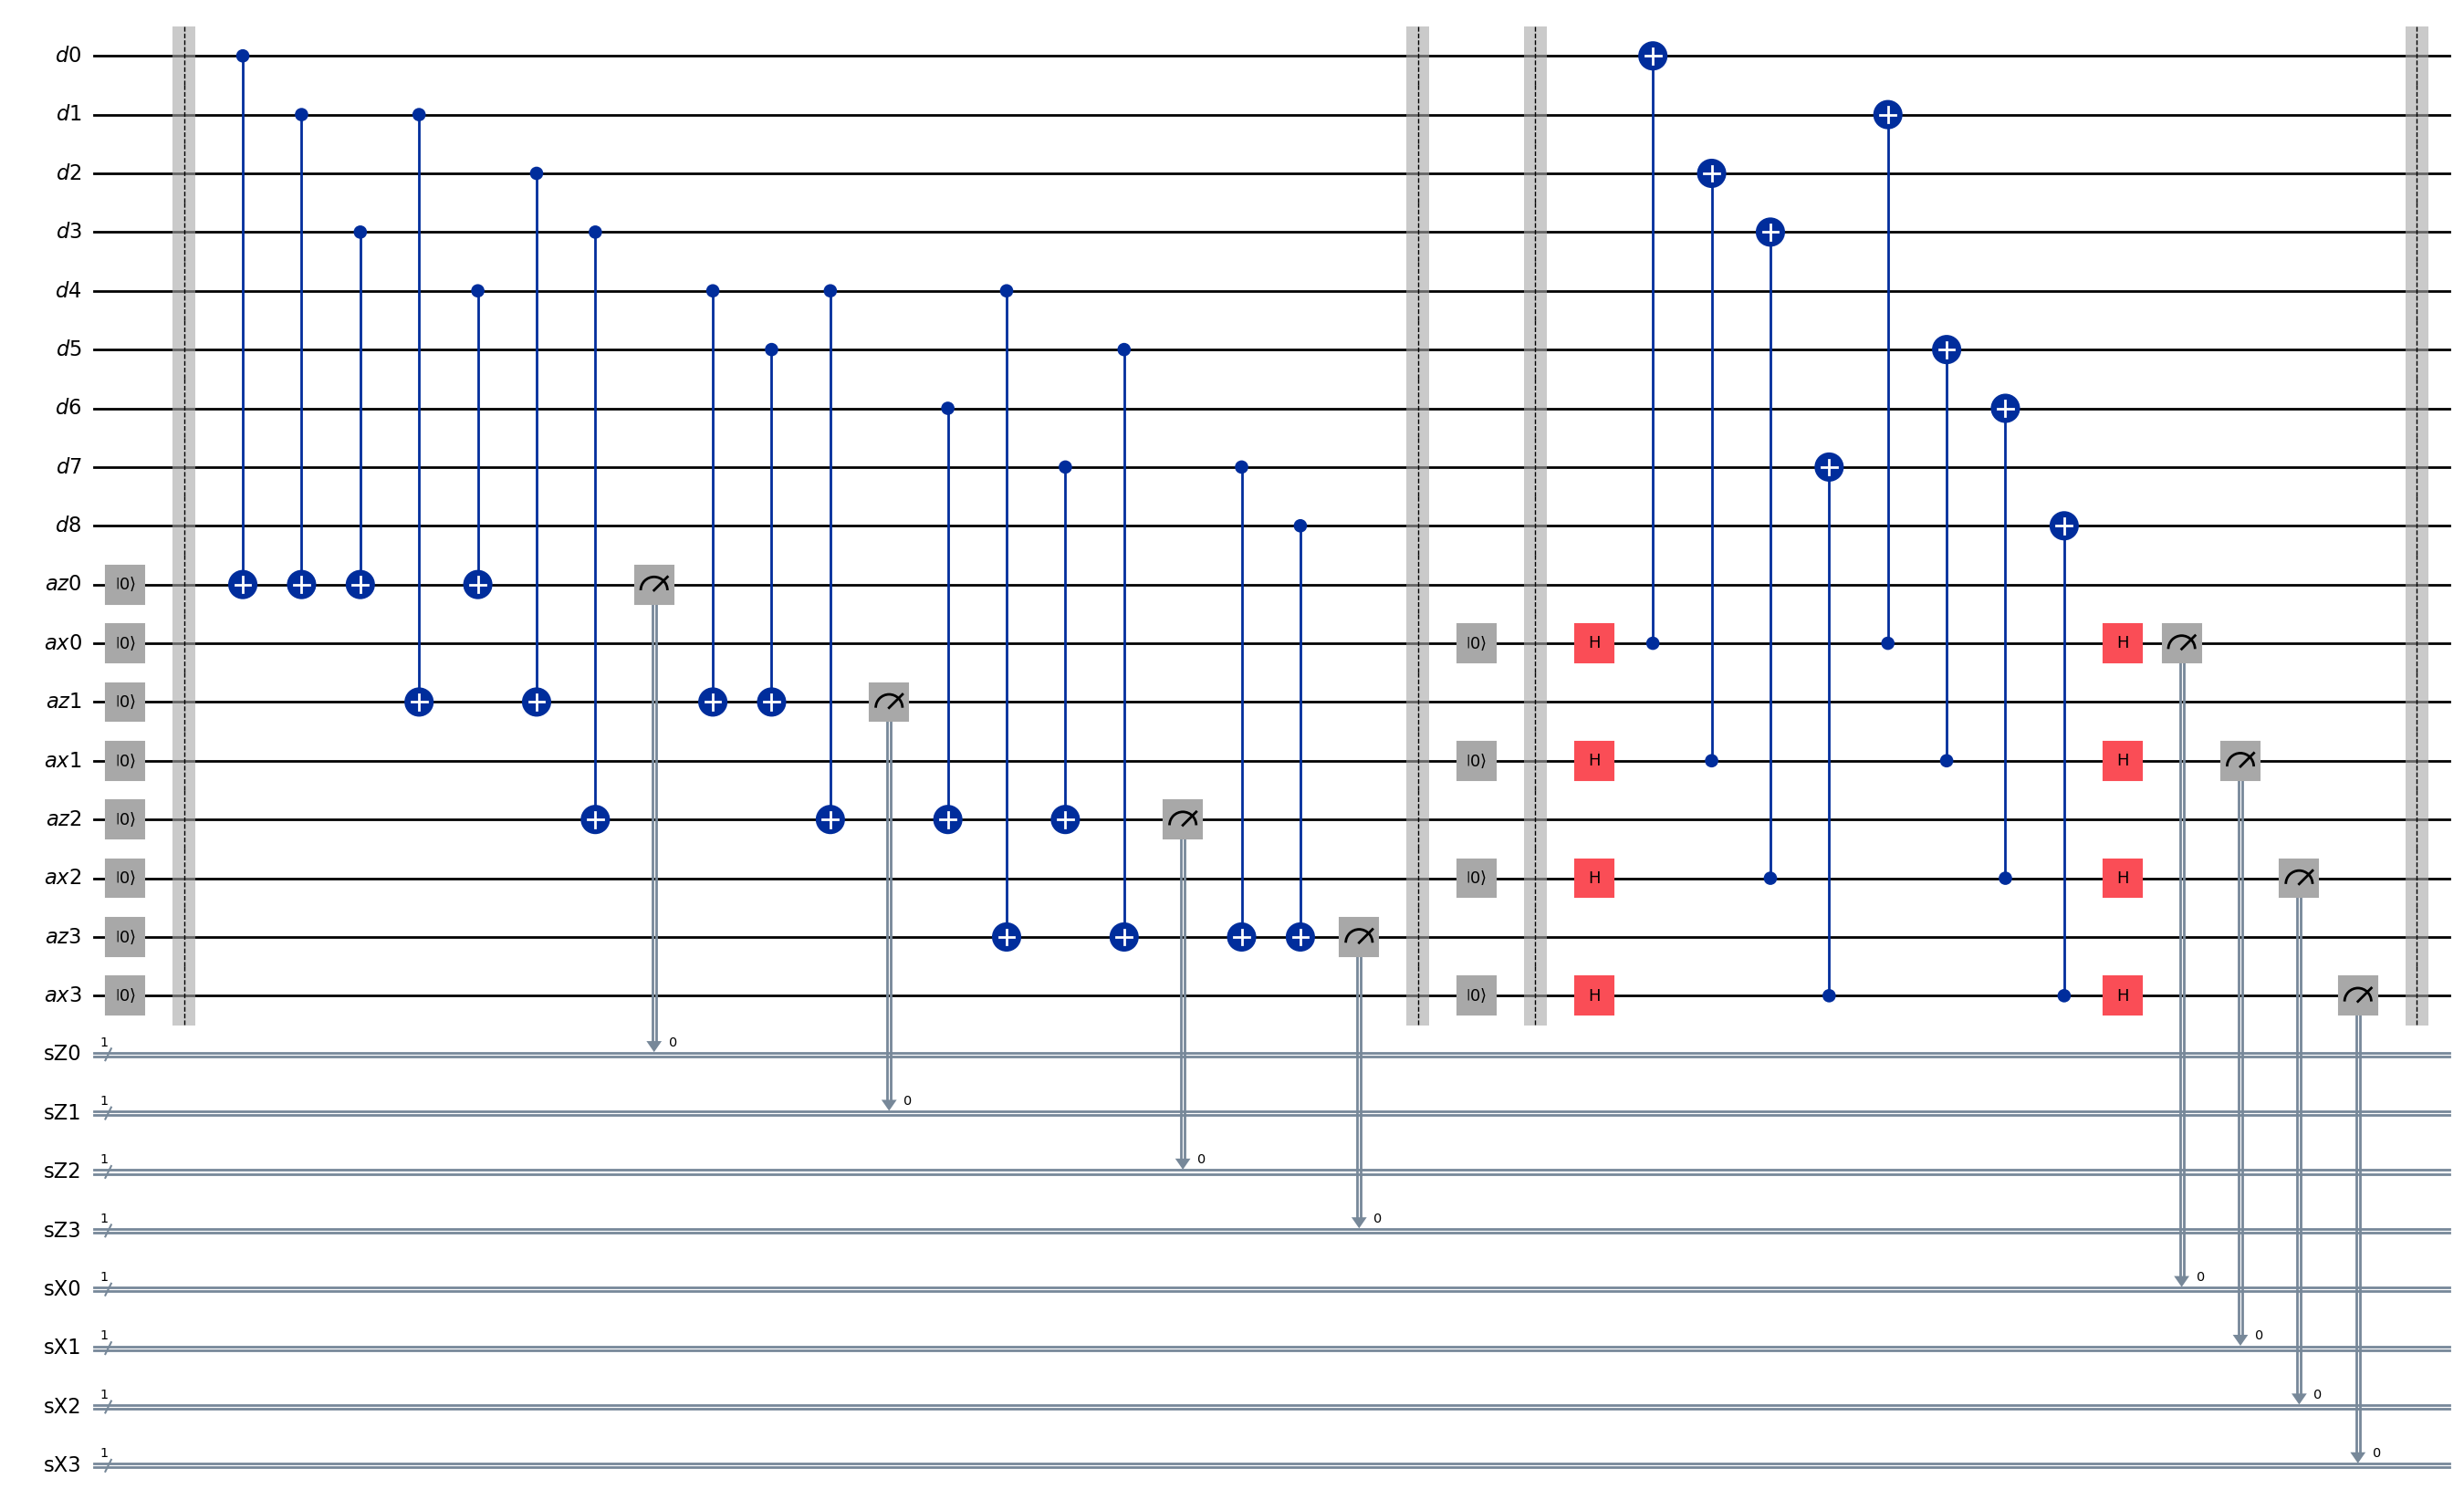

=== Round-1 circuit: inject X on d1, then one syndrome round ===


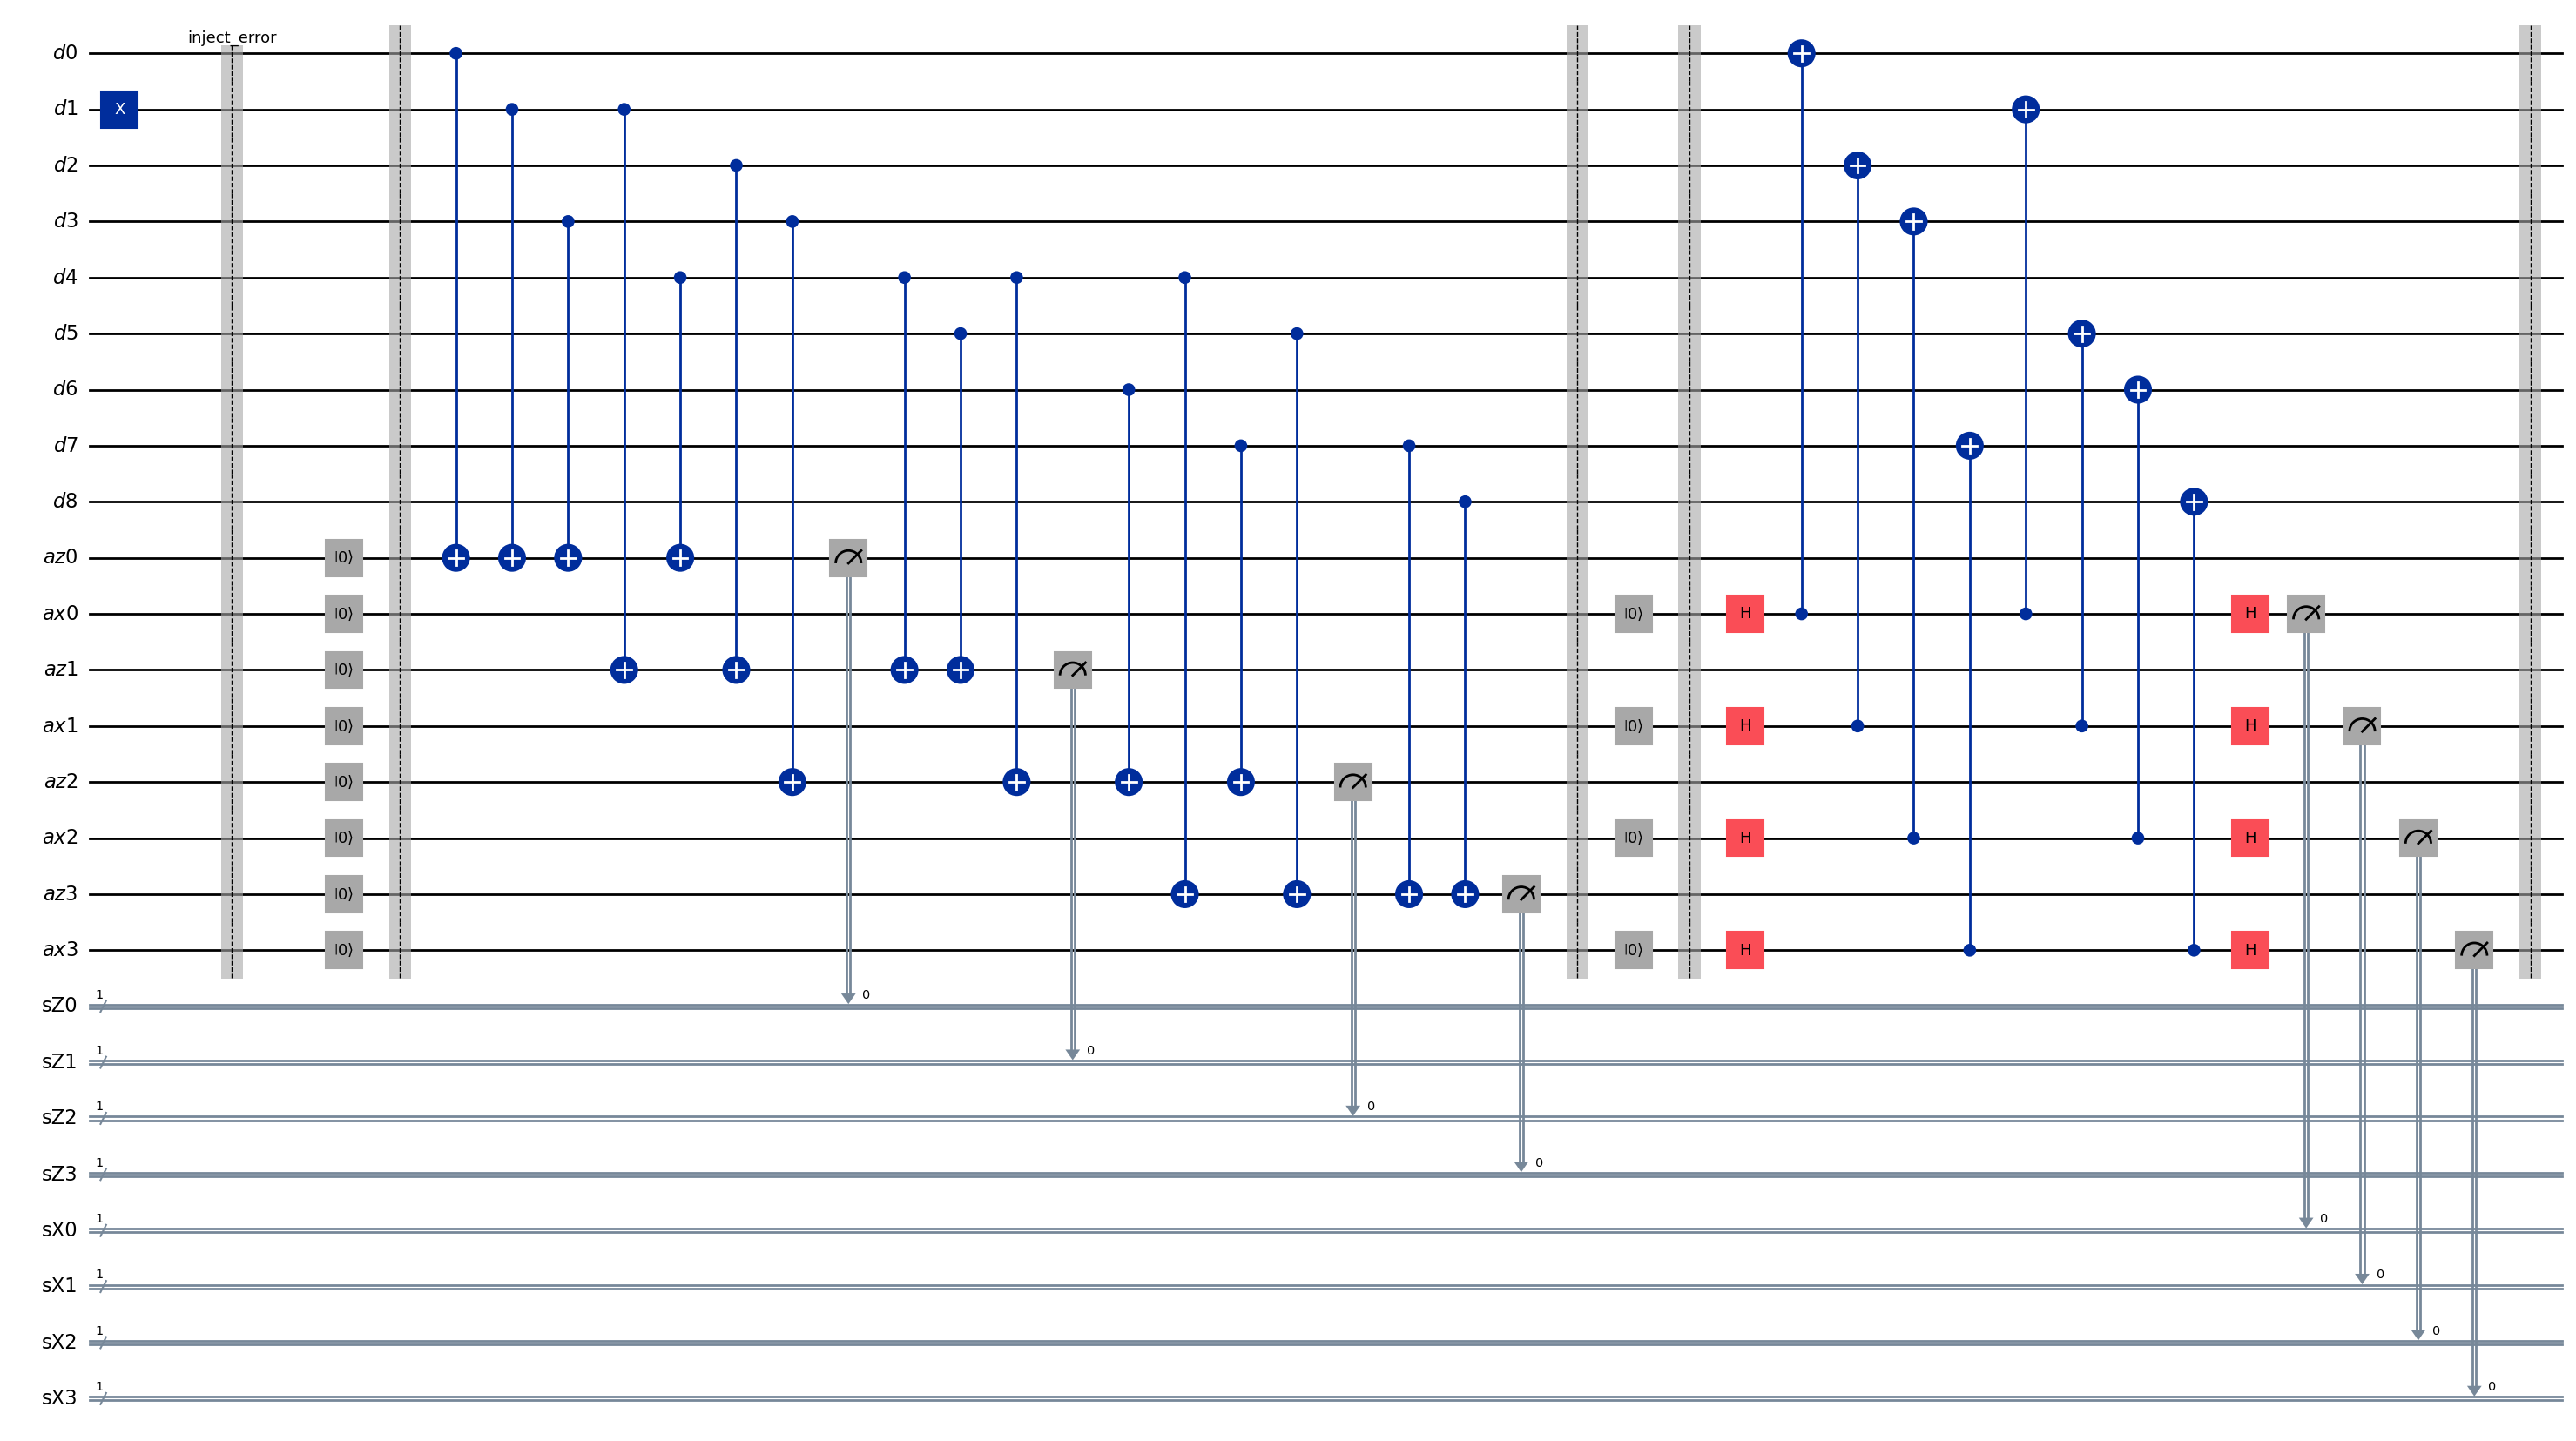

raw key  : 0 0 1 1 0 0 1 1
cleaned  : 00110011
selected : 00110011
sZ,sX    : [0, 0, 1, 1] [0, 0, 1, 1]

Round-1 counts: {'0 0 1 1 0 0 1 1': 1}
Round-1 sZ: [0, 0, 1, 1] (Z-check syndrome; X errors flip these)
Round-1 sX: [0, 0, 1, 1] (X-check syndrome; Z errors flip these)
Toy decoder guess (single-X): d7

=== Round-2 circuit: apply correction, then one syndrome round (verification) ===


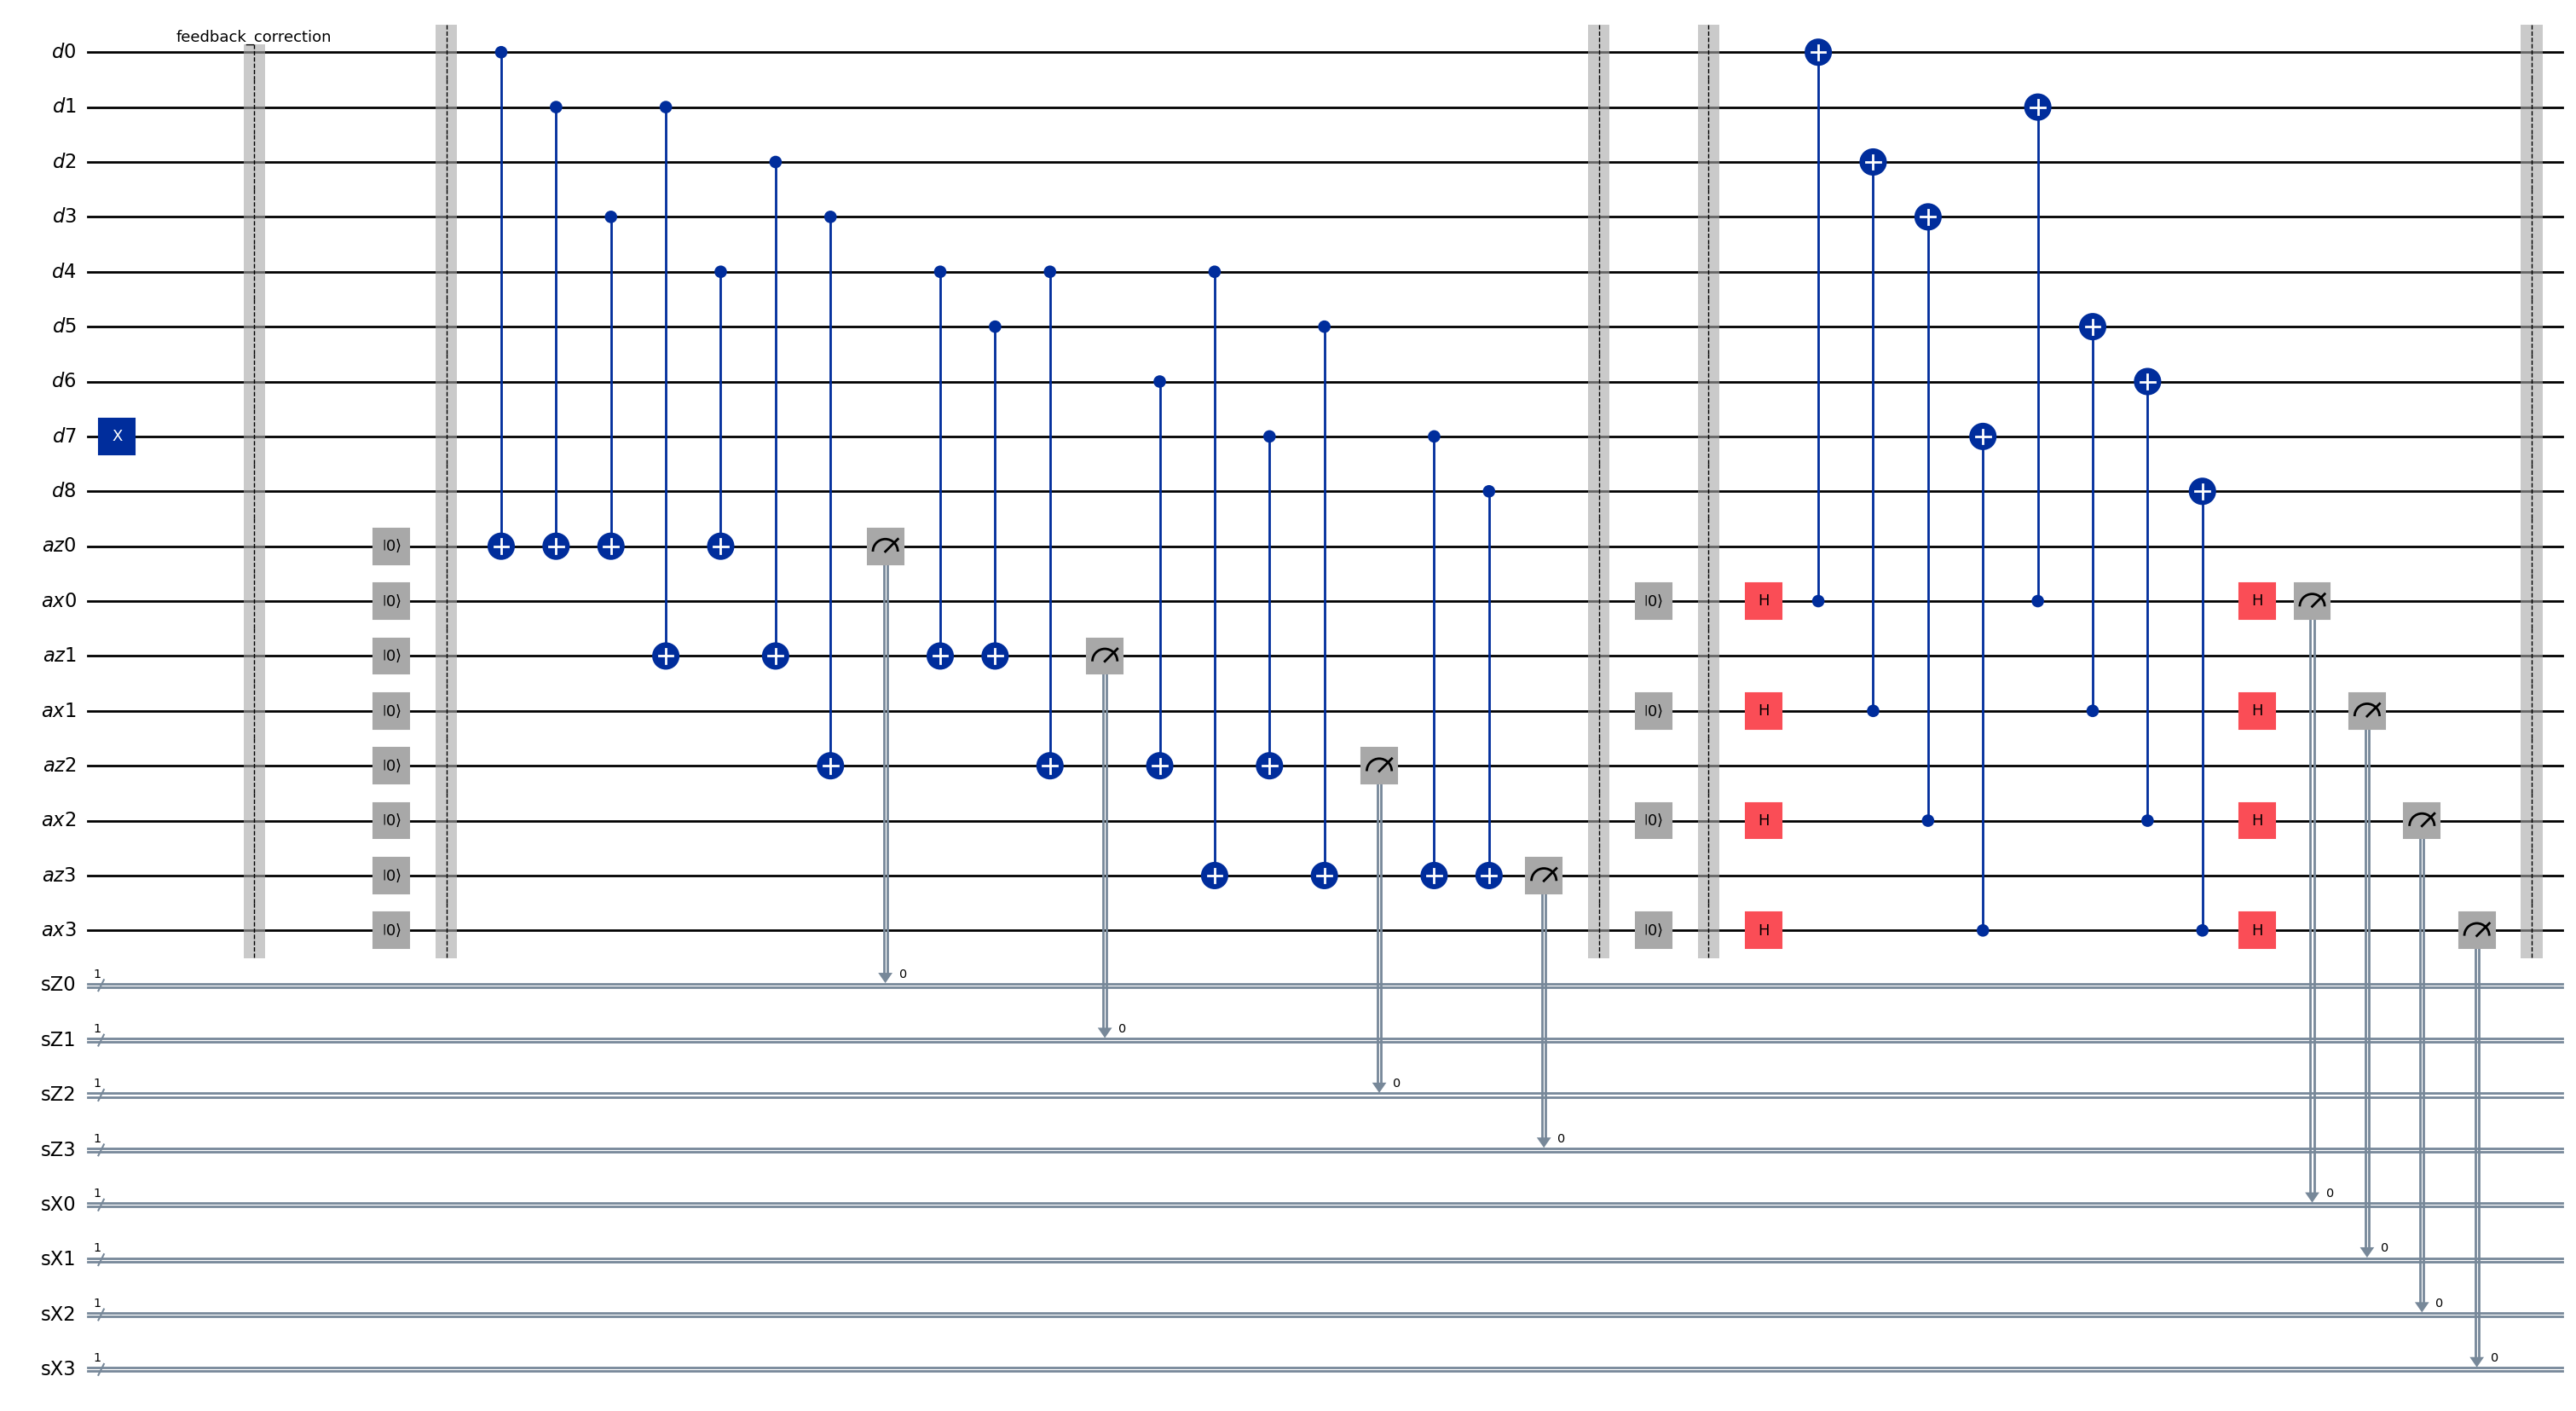

raw key  : 1 1 1 1 1 1 0 0
cleaned  : 11111100
selected : 11111100
sZ,sX    : [1, 1, 1, 1] [1, 1, 0, 0]

Round-2 counts: {'1 1 1 1 1 1 0 0': 1}
Round-2 sZ: [1, 1, 1, 1] sX: [1, 1, 0, 0]


In [14]:
import re
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit import QuantumCircuit

# =========================
# 纠错示例（带电路展示）：完整 Section
# =========================

backend = AerSimulator()

def run_once_get_bitstring(qc, shots=1):
    tqc = transpile(qc, backend)
    res = backend.run(tqc, shots=shots).result()
    counts = res.get_counts()
    bitstring = list(counts.keys())[0]
    return bitstring, counts

def parse_syndrome(bitstring, expect_bits=8, reverse=False, take_last=True, verbose=False):
    clean = re.sub(r'[^01]', '', bitstring)
    if len(clean) < expect_bits:
        raise ValueError(f"Counts key parsed to <{expect_bits} bits: raw='{bitstring}', cleaned='{clean}'")

    sel = clean[-expect_bits:] if take_last else clean[:expect_bits]
    sel = sel[::-1] if reverse else sel

    bits = [int(b) for b in sel]
    sZ = bits[0:4]
    sX = bits[4:8]

    if verbose:
        print("raw key  :", bitstring)
        print("cleaned  :", clean)
        print("selected :", sel)
        print("sZ,sX    :", sZ, sX)

    return sZ, sX, bits, sel, clean

def build_single_X_lookup():
    lookup = {}
    for i in range(9):
        d = f"d{i}"
        pattern = tuple(1 if d in stab["data"] else 0 for stab in Z_CHECKS)  # (sZ0..sZ3)
        lookup[pattern] = d
    return lookup

X_LOOKUP = build_single_X_lookup()

# ---------- 电路构造：把“模板电路”用于纠错 ----------
def inject_error_then_round(err_type="X", err_data="d1"):
    """
    Round-1：在 data 上注入错误，然后接上 build_one_round() 这一轮综合征提取模板。
    """
    qregs = make_named_qubits()
    cregs = make_named_syndrome_bits()
    qc = QuantumCircuit(*qregs.values(), *cregs.values(), name="Round1_inject_then_round")

    # 1) 注入错误（这是纠错流程里“系统发生错误”的那一步）
    if err_type.upper() == "X":
        qc.x(Q(qregs, err_data))
    elif err_type.upper() == "Z":
        qc.z(Q(qregs, err_data))
    else:
        raise ValueError("err_type must be 'X' or 'Z'")

    qc.barrier(label="inject_error")

    # 2) 接上“模板电路”（这就是你上一 section 生成的 one-round syndrome extraction）
    qc.compose(build_one_round(), inplace=True)

    return qc

def feedback_then_round(correction_data=None):
    """
    Round-2：根据解码结果进行反馈纠正（教学版显式打 X），再接一轮 build_one_round() 验证。
    """
    qregs = make_named_qubits()
    cregs = make_named_syndrome_bits()
    qc = QuantumCircuit(*qregs.values(), *cregs.values(), name="Round2_feedback_then_round")

    # 3) 反馈纠正（真实系统通常是更新 Pauli frame；这里为了直观“真的打一个门”）
    if correction_data is not None:
        qc.x(Q(qregs, correction_data))
    qc.barrier(label="feedback_correction")

    # 4) 再测一轮 syndrome（验证是否回到全 0）
    qc.compose(build_one_round(), inplace=True)

    return qc

# ---------- 先展示“模板电路” ----------
print("=== Template circuit: one round syndrome extraction (build_one_round) ===")
qc_template = build_one_round()
display(qc_template.draw("mpl", fold=-1))

# ---------- Round-1：注入错误 + 模板电路 ----------
qc_err = inject_error_then_round(err_type="X", err_data="d1")
print("=== Round-1 circuit: inject X on d1, then one syndrome round ===")
display(qc_err.draw("mpl", fold=-1))

key1, counts1 = run_once_get_bitstring(qc_err, shots=1)
sZ1, sX1, _, sel1, _ = parse_syndrome(key1, expect_bits=8, reverse=False, take_last=True, verbose=True)

print("\nRound-1 counts:", counts1)
print("Round-1 sZ:", sZ1, "(Z-check syndrome; X errors flip these)")
print("Round-1 sX:", sX1, "(X-check syndrome; Z errors flip these)")

# 解码（教学版：仅用 sZ 查表定位单个 X 错误）
guess = X_LOOKUP.get(tuple(sZ1), None)
print("Toy decoder guess (single-X):", guess)

# ---------- Round-2：反馈纠正 + 再测一轮 ----------
qc_fb = feedback_then_round(guess)
print("\n=== Round-2 circuit: apply correction, then one syndrome round (verification) ===")
display(qc_fb.draw("mpl", fold=-1))

key2, counts2 = run_once_get_bitstring(qc_fb, shots=1)
sZ2, sX2, _, sel2, _ = parse_syndrome(key2, expect_bits=8, reverse=False, take_last=True, verbose=True)

print("\nRound-2 counts:", counts2)
print("Round-2 sZ:", sZ2, "sX:", sX2)


---

## 5. 下一步（工业线路）

- 多轮（T>2）+ 时间相关解码（MWPM）：构建 3D syndrome graph  
- no-hook 调度：为 4-body stabilizer 选择更安全的两比特门顺序  
- CZ 原生门版：把 CNOT 编译/分解成 CZ + 单比特门，并按硬件耦合图调度  
- 加入噪声：门误差、测量误差、泄漏，评估逻辑错误率
